In [62]:
# Importing Data
import pickle
from data_creation import get_pickle, show_img

# Data Manipulation and Model Loading
import pandas as pd
import numpy as np
import keras
from keras import models
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.models import load_model
import os
import cv2
from keras.metrics import Precision, Recall
from keras.models import model_from_json

# Visualization
import matplotlib.pyplot as plt
import pydot_ng as pydot
keras.utils.vis_utils.pydot = pydot

## Importing Data

In [63]:
X_grayscale, y_grayscale = get_pickle('X_grayscale.pickle', 'y_grayscale.pickle')
X_color, y_color = get_pickle('X_color.pickle', 'y_color.pickle')

In [64]:
pickle_predictions = open('model_predictions.pickle', 'rb')
predictions = pickle.load(pickle_predictions)
pickle_predictions.close()

In [65]:
categories = ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango',
              'Muskmelon', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya',
              'Plum', 'Pomegranate', 'Tomato']

#### Converting the integer inputs to their proper labels

In [66]:
predictions['Actual'] = predictions.Actual.apply(lambda x: categories[x])
predictions['Predicted'] = predictions.Predicted.apply(lambda x: categories[x])

## Class Distribution

In [67]:
labels, counts = np.unique(y_grayscale, return_counts=True)
counts = counts/counts.sum()
fruit_counts = dict(sorted(zip(categories, counts), key=lambda x: x[1], reverse=True))

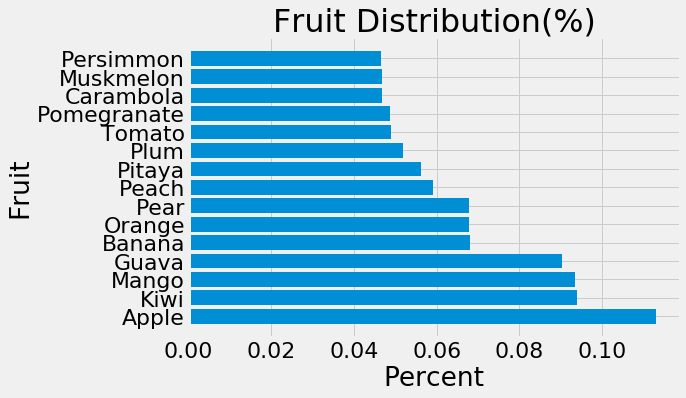

In [68]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,6))
plt.barh(list(fruit_counts.keys()), list(fruit_counts.values()))
plt.xlabel('Percent')
plt.ylabel('Fruit')
plt.title('Fruit Distribution(%)')
plt.tight_layout()
plt.savefig('Images/fruit_dist.png', transparent=True)

## Exploring Model Predictions

In [69]:
true_label_spread = dict(predictions.Actual.value_counts())
predicted_label_spread = dict(predictions.Predicted.value_counts())

Combining the values into a dict so that the indices match

In [70]:
difference_dict = {}
for k in true_label_spread:
    difference_dict[k] = (-true_label_spread[k]+predicted_label_spread[k])

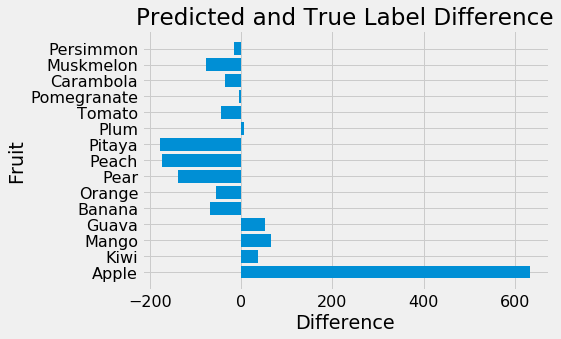

In [89]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 16})
plt.barh(list(difference_dict.keys()), list(difference_dict.values()))
plt.ylabel('Fruit')
plt.xlabel('Difference')
plt.title('Predicted and True Label Difference')
plt.tight_layout()
plt.savefig('Images/true_pred_spread.png', transparent=True)

### Closer look at Incorrect Predictions

It missed 1,715 predictions.

In [72]:
predictions[predictions.Actual!=predictions.Predicted]

,Actual,Predicted
23,Muskmelon,Apple
73,Pitaya,Apple
142,Pear,Apple
148,Apple,Kiwi
159,Orange,Apple
...,...,...
44271,Pitaya,Apple
44311,Pitaya,Apple
44323,Pitaya,Apple
44328,Banana,Mango


Getting the incorrect predictions for each class. Then, for each class's set of predictions I change the amounts to percents.

In [73]:
wrong_preds = {}
for category in categories:
    temp_df = predictions[(predictions['Actual']==category)&(predictions['Predicted']!=category)]
    percents = dict(temp_df.Predicted.value_counts(normalize=True))
    wrong_preds[category]=percents
wrong_preds_df = pd.DataFrame(wrong_preds)

NA values will be filledin as 0.0

In [74]:
wrong_preds_df.fillna(0.0, inplace=True)

In [75]:
wrong_preds_df

,Apple,Banana,Carambola,Guava,Kiwi,Mango,Muskmelon,Orange,Peach,Pear,Persimmon,Pitaya,Plum,Pomegranate,Tomato
Muskmelon,0.283784,0.004739,0.000000,0.071429,0.000000,0.018349,0.000000,0.000000,0.0,0.068493,0.000000,0.000000,0.0,0.000000,0.0
Guava,0.198198,0.099526,0.488889,0.000000,0.152174,0.000000,0.133333,0.000000,0.0,0.086758,0.000000,0.000000,0.0,0.014085,0.0
Pear,0.184685,0.047393,0.000000,0.023810,0.065217,0.055046,0.115152,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Kiwi,0.157658,0.052133,0.000000,0.166667,0.000000,0.009174,0.012121,0.000000,0.0,0.036530,0.256410,0.000000,0.0,0.028169,0.0
Tomato,0.108108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042254,0.0,0.000000,0.051282,0.000000,0.0,0.000000,0.0
Pomegranate,0.022523,0.165877,0.088889,0.000000,0.043478,0.119266,0.000000,0.084507,0.0,0.004566,0.000000,0.000000,0.0,0.000000,0.0
Peach,0.013514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.005556,0.0,0.000000,0.0
Mango,0.009009,0.507109,0.266667,0.047619,0.021739,0.000000,0.000000,0.352113,0.0,0.013699,0.000000,0.000000,0.0,0.281690,0.0
Pitaya,0.009009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
Carambola,0.009009,0.004739,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


The columns are the true labels and the indices are the predicted label. Each value is the percent that that predicted label is of incorrect labels.
For example, we will look at the incorrectly predicted labels for Apple's below. We can see that of the incorrectly the all the incorrect labels the model made for apples, 78.37% were marked as pears.

In [76]:
wrong_preds_df['Apple']

Muskmelon      0.283784
Guava          0.198198
Pear           0.184685
Kiwi           0.157658
Tomato         0.108108
Pomegranate    0.022523
Peach          0.013514
Mango          0.009009
Pitaya         0.009009
Carambola      0.009009
Persimmon      0.004505
Apple          0.000000
Banana         0.000000
Plum           0.000000
Orange         0.000000
Name: Apple, dtype: float64

## Visualizing CNN Architecture

Load Model 8. This structure can be used to load any model. I load the model from the json file first and then grab the weights.

In [77]:
json = open('Models/model8.json', 'r')
model_8_json = json.read()
json.close()
model_8 = model_from_json(model_8_json)
model_8.load_weights("Models/model_weights_8.h5")

#### Compiling my model together from the imported files

In [78]:
model_8.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['categorical_accuracy', Precision(), Recall()])

I need this to make the model visualization work

In [79]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Visualizing my best model

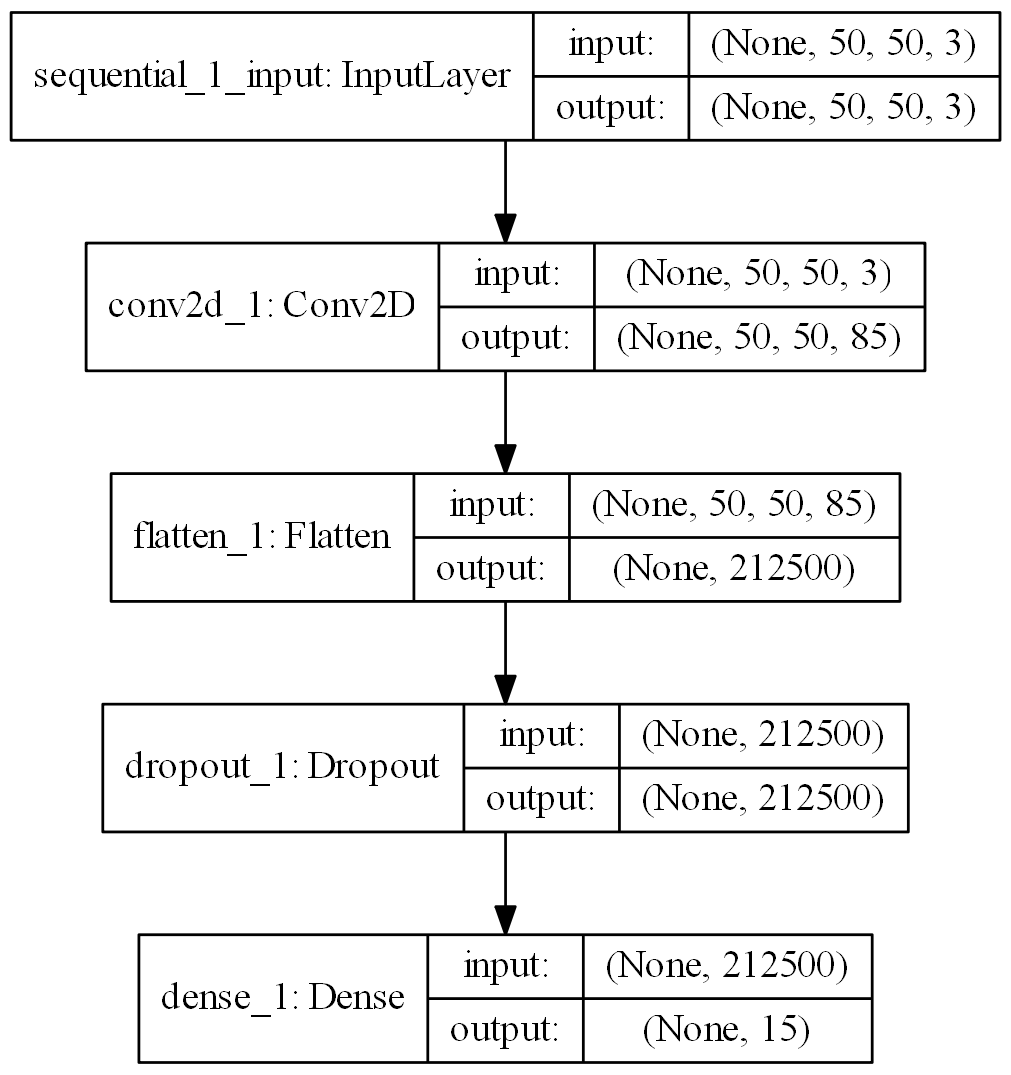

In [80]:
plot_model(model_8, to_file='Images/model.png',dpi=200, show_shapes=True)

## Further Breakdown of CNN

In [81]:
path = 'C://Users/Cristian/Documents/flatiron/Capstone/Fruit/Orange/Orange002.png'

I will grab the first image of a Pitaya to show what the model does on the first and last layer.

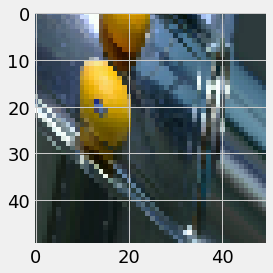

In [82]:
example = show_img(path,50)
plt.savefig('Images/example.png', transparent=True)

In [83]:
layer_outputs = [layer.output for layer in model_8.layers[:4]]
activation_model = models.Model(inputs=model_8.input, outputs=layer_outputs)

In [84]:
activations = activation_model.predict(example.reshape(1,50,50,3))

In [85]:
first_layer = activations[0]

I want to visualize what my neurons are picking up on. To do this, I will select 10 neurons at random and plot them all side by side.
I will use a color map to show what it is picking up on and what it does not.

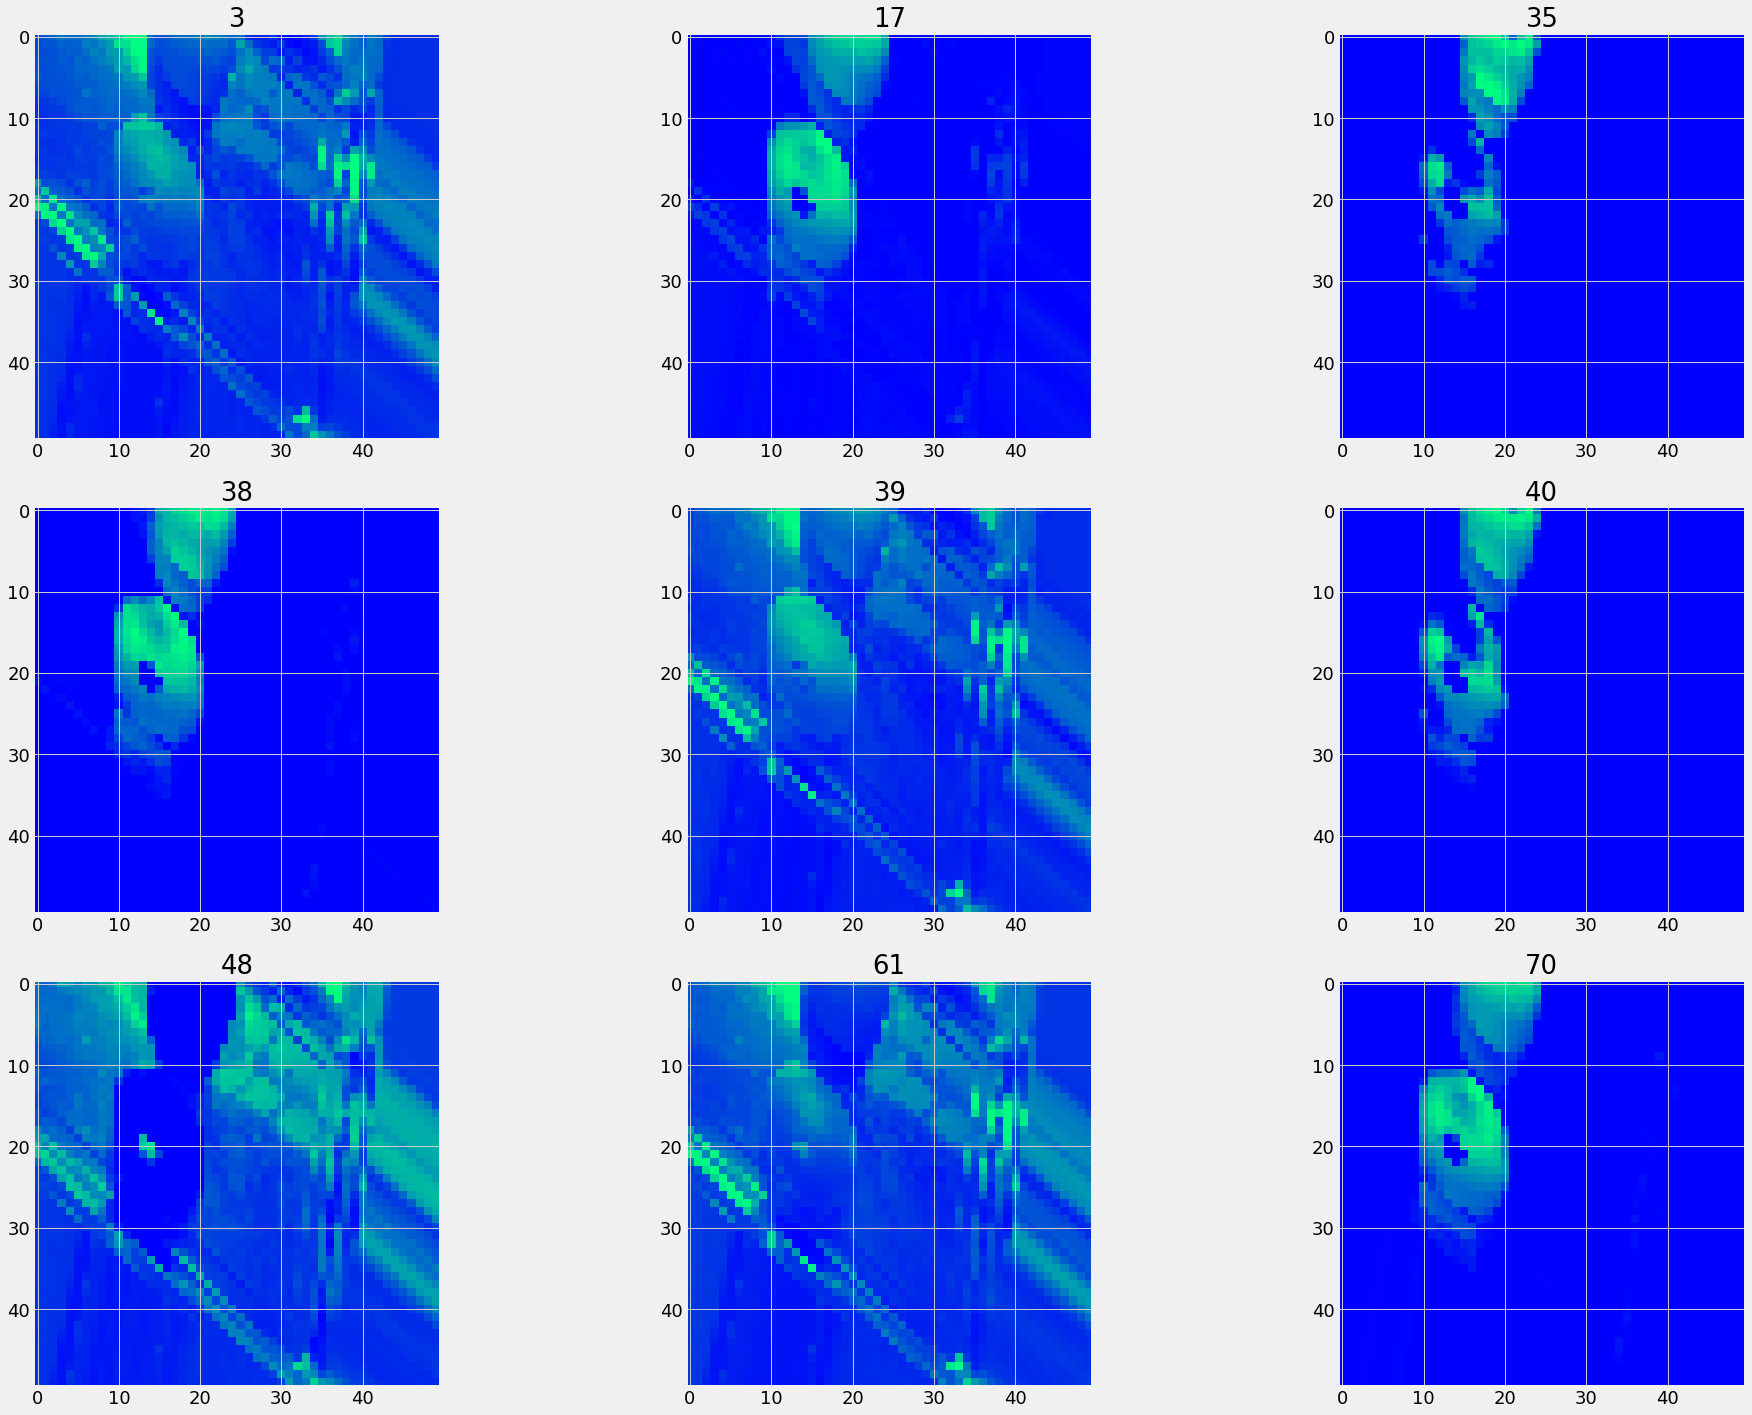

In [27]:
fig=plt.figure(figsize=(30,20))
columns=3
rows=3
my_9 = sorted(np.random.choice(85,9,replace=False))

for i in range(1, columns*rows+1):
    fig.add_subplot(rows,columns,i)
    for pic in my_9:
        plt.imshow(first_layer[0, :, :, my_9[i-1]],cmap='winter')
        plt.title(str(my_9[i-1]))
plt.tight_layout()
plt.savefig('Images/example_breakdown.png', transparent=True)
plt.show()

As we can see, some of the neurons are picking up on trends in the shape of our pitaya. Others seem to pick up nothing at all. There are also neurons
that are picking up on the background of our photo. It seems to be picking up on the shine of the metal tray all fruits are being placed on. 

Below I will look visualize how the last layer is outputting the predicted value.

(1, 15)


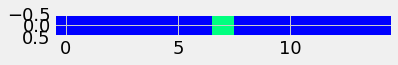

In [61]:
last_layer = activations[3]
print(last_layer.shape)
plt.imshow(last_layer, cmap='winter')
plt.rcParams.update({'font.size': 22})
plt.tight_layout()
plt.savefig('Images/output_layer.png', transparent=True)

As seen, the plot is from 0 to 14, an integer for each of the classes of fruit. My model predicted an output of 11, which corresponds to the index of 'categories'.

In [29]:
categories[7]

'Orange'